# Read in the data

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [3]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [11]:
%matplotlib inline

In [12]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

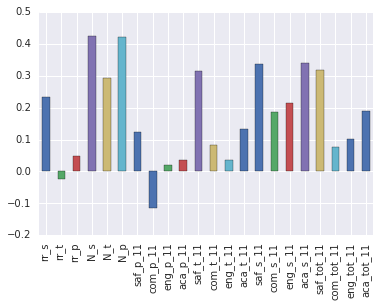

In [13]:
correlations[survey_fields].plot.bar()

The **number of student respondents** and the **number of parent respondents** have a strong positive correlation with the **sat score**. The **number of teacher respondents**  positively correlates with the **sat score** as well but less strongly.  
  
Furthermore, **student academic expectation score** and scores for **safty and respect** show a considerable correlation to the **sat score** 

## Safety Scores

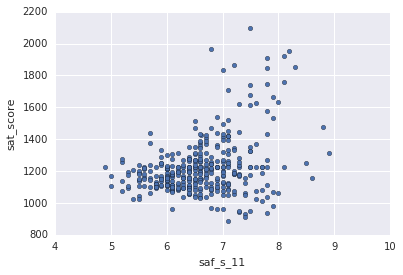

In [14]:
combined.plot.scatter('saf_s_11', 'sat_score')

Starting with **student safety and respect** scores of more than 6.5 much **higher sat scores** can be found. Interestingly, the lowest sat scores can also be found among these schools.

### Safety Score by Boroughs

In [15]:
grouped_boro = combined.groupby('boro')
grouped_boro['saf_s_11'].mean().sort_values(ascending=False)

boro
Manhattan        6.831370
Queens           6.721875
Bronx            6.606577
Staten Island    6.530000
Brooklyn         6.370755
Name: saf_s_11, dtype: float64

### Racial Group by Borough

In [17]:
r_columns = ['white_per', 'asian_per', 'black_per', 'hispanic_per']

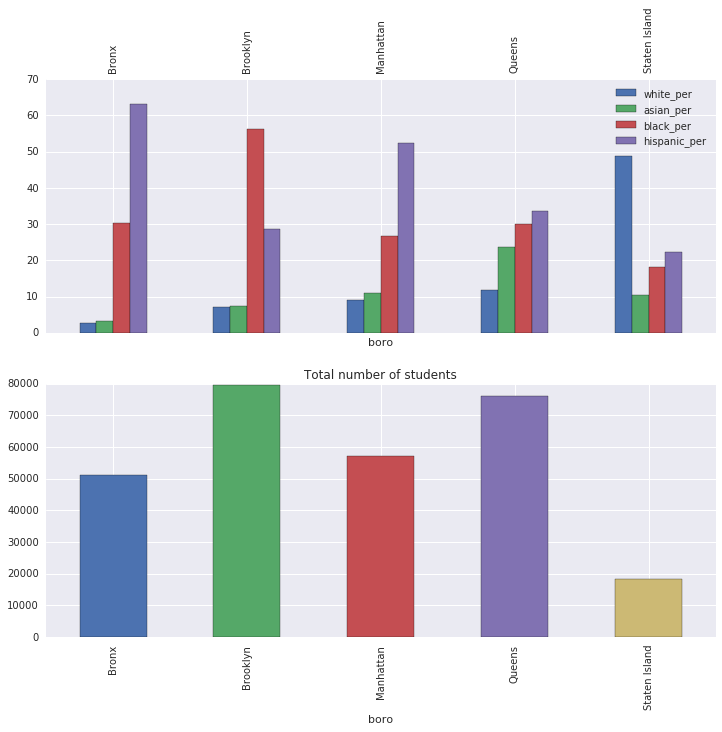

In [18]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(12,10))
ax1.xaxis.set_ticks_position("top")
grouped_boro[r_columns].mean().plot(kind='bar', ax=ax1)
grouped_boro['total_students'].sum().plot(kind='bar', ax=ax2, title='Total number of students')

### Correlation: Racial Group / Sat Score

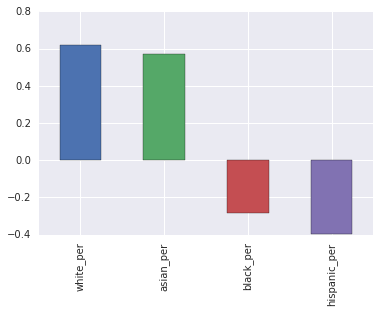

In [19]:
r_columns = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
correlations[r_columns].plot.bar()

The data reveal significant differences across the five boroughs of New York City. 

Across all boroughs, the **share of black and hispanic students correlate negatively with the sat score** while the inverse is true for the share of white and asian students.

Above, we established a correlation between sat scores and students' safety scores. Interestingly, in all three boroughs with the highest safety scores, hispanic students make up the largest share.

This indicates that the correlation between **student safety and respect score** and **sat score** - while correct for the complete dataset - might be quite inadequate when looking at the data in more detail.

### SAT Score / Share Hispanic Students

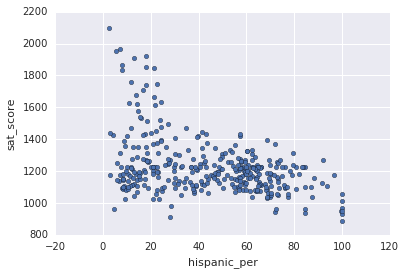

In [31]:
combined.plot.scatter('hispanic_per', 'sat_score')

In [21]:
high_hispanic_per = combined[combined['hispanic_per'] > 95][['school_name', 'hispanic_per', 'sat_score']]
high_hispanic_per.sort_values('hispanic_per', ascending=False)

,school_name,hispanic_per,sat_score
286,Pan American International High School,100.0,951.0
44,Manhattan Bridges High School,99.8,1058.0
89,Gregorio Luperon High School for Science and M...,99.8,1014.0
141,International School for Liberal Arts,99.8,934.0
176,Pan American International High School at Monroe,99.8,970.0
253,Multicultural High School,99.8,887.0
125,Academy for Language and Technology,99.4,951.0
82,Washington Heights Expeditionary Learning School,96.7,1174.0


In [22]:
crit1 = combined['hispanic_per'] < 10
crit2 = combined['sat_score'] > 1800
low_hispanic_per = combined[crit1 & crit2][['school_name', 'hispanic_per', 'sat_score']]
low_hispanic_per.sort_values('hispanic_per')

,school_name,hispanic_per,sat_score
37,Stuyvesant High School,2.4,2096.0
356,Staten Island Technical High School,5.3,1953.0
151,Bronx High School of Science,7.2,1969.0
187,Brooklyn Technical High School,7.9,1833.0
327,Queens High School for the Sciences at York Co...,7.9,1868.0


### Correlation: SAT Score / Gender

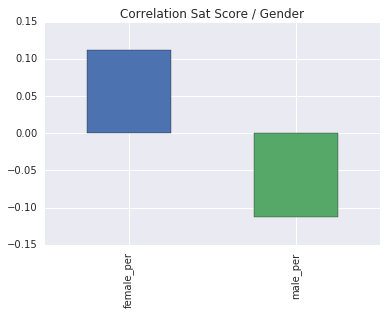

In [33]:
correlations[['female_per', 'male_per']].plot.bar(title='Correlation Sat Score / Gender')

There is a weak positive correlation between the average SAT score and the share of female students. Due to the fact that the school data does not offer further gender differentiation the correlation between the average SAT score and the share of male students is the inverse.

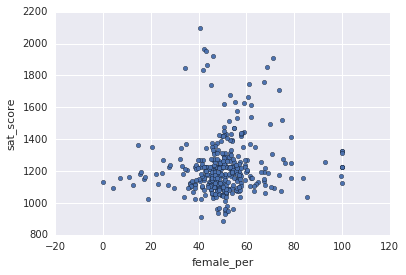

In [34]:
combined.plot.scatter('female_per', 'sat_score')

In [38]:
crit1 = combined['female_per'] > 60
crit2 = combined['sat_score'] > 1700
low_hispanic_per = combined[crit1 & crit2][['school_name', 'female_per', 'sat_score']]
low_hispanic_per.sort_values('female_per', ascending=False)

,school_name,female_per,sat_score
61,Fiorello H. LaGuardia High School of Music & A...,73.6,1707.0
302,Townsend Harris High School,71.1,1910.0
5,Bard High School Early College,68.7,1856.0
26,Eleanor Roosevelt High School,67.5,1758.0
60,Beacon High School,61.0,1744.0


### Share AP Test Takers

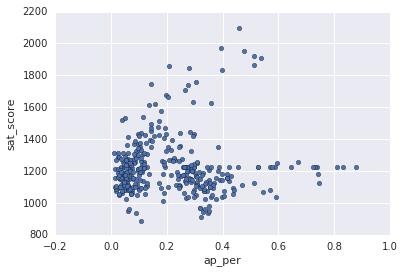

In [39]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']
combined.plot.scatter('ap_per', 'sat_score')

In [45]:
ap_sat_corr = combined[['ap_per', 'sat_score']].corr()
ap_sat_corr['sat_score']

ap_per       0.057171
sat_score    1.000000
Name: sat_score, dtype: float64

The correlation between the share of AP Test Takers and the SAT score overall is negligible. The scatter plot shows a diverging pattern, indicating the existence of other factors discerning the students decision to take an AP Test.